In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt

class Config:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    IMG_SIZE = 84  # Keep this consistent!
    N_WAY = 6
    K_SHOT = 5
    Q_QUERY = 15
    LEARNING_RATE = 0.001
    EPISODES = 1000
    VAL_EPISODES = 50
    MEAN_SHIFT_ITER = 5

# Re-define transform to ensure it captures the '84' from above
transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# RELOAD DATASET to apply the 84x84 transform
# (Assuming DATASET_PATH is defined from previous cells)
try:
    dataset = NEUFewShotDataset(root_dir=DATASET_PATH, mode='train', transform=transform)
    print(f"Dataset Reloaded. Image Size: {Config.IMG_SIZE}x{Config.IMG_SIZE}")
except NameError:
    print("Please define DATASET_PATH first (from the previous code block).")

Found 6 classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
 - Loaded 240 images for class 'crazing'
 - Loaded 240 images for class 'inclusion'
 - Loaded 240 images for class 'patches'
 - Loaded 240 images for class 'pitted_surface'
 - Loaded 240 images for class 'rolled-in_scale'
 - Loaded 240 images for class 'scratches'
Dataset Reloaded. Image Size: 84x84


In [23]:
import os
import random
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class NEUFewShotDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        """
        Args:
            root_dir (str): Path to the 'images' folder containing class subfolders.
                            Based on your image: /kaggle/input/neu-surface-defect-database/NEU-DET/train/images
        """
        self.transform = transform
        self.mode = mode
        self.root_dir = root_dir
        self.data = {} # {class_name: [image_path, ...]}

        # --- CORRECTED LOADING LOGIC ---
        if os.path.exists(root_dir):
            self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
            self.classes.sort() # Ensure consistent order
            
            print(f"Found {len(self.classes)} classes: {self.classes}")

            for cls in self.classes:
                cls_path = os.path.join(root_dir, cls)
                # Get all valid image files
                imgs = [os.path.join(cls_path, f) for f in os.listdir(cls_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                self.data[cls] = imgs
                print(f" - Loaded {len(imgs)} images for class '{cls}'")
        else:
            raise FileNotFoundError(f"Directory not found: {root_dir}. Please check the path in Kaggle 'Data' tab.")

    def __len__(self):
        return sum(len(imgs) for imgs in self.data.values())

    def get_episode(self, n_way, k_shot, q_query):
        """Samples an episode: N-way, K-shot support, Q-query"""
        # Randomly select N classes
        sampled_classes = random.sample(self.classes, n_way)
        
        support_imgs = []
        support_labels = []
        query_imgs = []
        query_labels = []

        for i, cls in enumerate(sampled_classes):
            # Select K + Q images from this class
            # Note: If a class has fewer images than needed, we sample with replacement or limit it
            available_imgs = self.data[cls]
            if len(available_imgs) < (k_shot + q_query):
                # Fallback for small classes: sample with replacement
                imgs = random.choices(available_imgs, k=k_shot + q_query)
            else:
                imgs = random.sample(available_imgs, k_shot + q_query)
            
            # Split into support and query
            s_imgs = imgs[:k_shot]
            q_imgs = imgs[k_shot:]
            
            # Load images
            for p in s_imgs:
                support_imgs.append(self.load_image(p))
                support_labels.append(i)
                
            for p in q_imgs:
                query_imgs.append(self.load_image(p))
                query_labels.append(i)

        return (torch.stack(support_imgs), torch.tensor(support_labels), 
                torch.stack(query_imgs), torch.tensor(query_labels))

    def load_image(self, path):
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# --- CONFIGURATION ---
# IMPORTANT: Adjust this path if your Kaggle dataset name is different.
# I am guessing the generic Kaggle mount point based on your folder name.
DATASET_PATH = "/kaggle/input/neu-surface-defect-database/NEU-DET/train/images" 

# If the above fails, try: "/kaggle/input/neu-det/NEU-DET/train/images"

transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet stats
])

try:
    dataset = NEUFewShotDataset(root_dir=DATASET_PATH, mode='train', transform=transform)
except FileNotFoundError as e:
    print(e)
    print("Please copy the 'Path' from the Data Explorer in the right sidebar of your Kaggle notebook.")

Found 6 classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
 - Loaded 240 images for class 'crazing'
 - Loaded 240 images for class 'inclusion'
 - Loaded 240 images for class 'patches'
 - Loaded 240 images for class 'pitted_surface'
 - Loaded 240 images for class 'rolled-in_scale'
 - Loaded 240 images for class 'scratches'


In [24]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        
        # We compress the channel dimension to 2 (Max and Avg pool)
        # Then use a convolution to produce a 1-channel spatial mask
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # AvgPool and MaxPool across channels
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate results
        x_cat = torch.cat([avg_out, max_out], dim=1)
        
        # Convolve and Sigmoid to get Attention Map
        out = self.conv1(x_cat)
        mask = self.sigmoid(out)
        
        # Element-wise multiplication: Feature * Mask
        return x * mask

In [25]:
class AR_Backbone(nn.Module):
    def __init__(self):
        super(AR_Backbone, self).__init__()
        
        # Standard CNN layers
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, 3, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        
        self.attention = SpatialAttention(kernel_size=7)
        
        # --- ROBUST FLATTEN CALCULATION ---
        # Instead of manual math, we run a dummy variable to get the exact size.
        with torch.no_grad():
            dummy = torch.zeros(1, 3, Config.IMG_SIZE, Config.IMG_SIZE)
            out = self.layer1(dummy)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.attention(out)
            self.flatten_dim = out.view(1, -1).shape[1]
            print(f"Backbone initialized. Flattened Dim: {self.flatten_dim}")
            
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 512) 

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.attention(out)
        
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        # Feature Normalization (Critical for Few-Shot)
        return F.normalize(out, p=2, dim=1)

In [26]:
# UPDATE CELL 5: AR_MSProNet
class AR_MSProNet(nn.Module):
    def __init__(self, backbone):
        super(AR_MSProNet, self).__init__()
        self.backbone = backbone
        self.use_mean_shift = False  # Toggle this flag

    def gaussian_kernel(self, distance, h=1.0):
        return torch.exp(-0.5 * (distance / h) ** 2)

    def mean_shift_prototype(self, support_embeddings, support_labels, n_way, k_shot):
        # 1. Initial Prototypes (Simple Mean) - This is CL-ProNet
        prototypes = torch.zeros(n_way, support_embeddings.size(1)).to(Config.DEVICE)
        
        for i in range(n_way):
            mask = (support_labels == i)
            if mask.sum() > 0:
                prototypes[i] = support_embeddings[mask].mean(dim=0)
        
        # 2. Return early if Mean-Shift is disabled (Warm-up phase)
        if not self.use_mean_shift:
            return prototypes

        # 3. Apply Mean-Shift Refinement (Only after warm-up)
        for i in range(n_way):
            class_mask = (support_labels == i)
            class_samples = support_embeddings[class_mask]
            current_proto = prototypes[i]
            
            for _ in range(Config.MEAN_SHIFT_ITER):
                dists = torch.sum((class_samples - current_proto) ** 2, dim=1)
                weights = self.gaussian_kernel(dists)
                numerator = torch.sum(weights.unsqueeze(1) * class_samples, dim=0)
                denominator = torch.sum(weights) + 1e-8
                current_proto = numerator / denominator
                
            prototypes[i] = current_proto
            
        return prototypes

    def forward(self, support_x, support_y, query_x):
        support_emb = self.backbone(support_x)
        query_emb = self.backbone(query_x)
        
        prototypes = self.mean_shift_prototype(support_emb, support_y, Config.N_WAY, Config.K_SHOT)
        
        # Distance scaling can also help convergence
        dists = torch.pow(query_emb.unsqueeze(1) - prototypes.unsqueeze(0), 2).sum(2)
        return -dists

In [27]:
def train_episode(model, optimizer, dataset, n_way, k_shot, q_query):
    model.train()
    
    # Sample one episode
    sx, sy, qx, qy = dataset.get_episode(n_way, k_shot, q_query)
    sx, sy, qx, qy = sx.to(Config.DEVICE), sy.to(Config.DEVICE), qx.to(Config.DEVICE), qy.to(Config.DEVICE)
    
    optimizer.zero_grad()
    
    # Forward pass
    output_dists = model(sx, sy, qx) # (N*Q, N_WAY)
    
    # Loss (Cross Entropy equivalent for LogSoftmax outputs)
    loss = F.cross_entropy(output_dists, qy)
    
    # Backward
    loss.backward()
    optimizer.step()
    
    # Accuracy
    _, preds = torch.max(output_dists, 1)
    acc = (preds == qy).float().mean()
    
    return loss.item(), acc.item()

def validate(model, dataset, n_episodes):
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for _ in range(n_episodes):
            sx, sy, qx, qy = dataset.get_episode(Config.N_WAY, Config.K_SHOT, Config.Q_QUERY)
            sx, sy, qx, qy = sx.to(Config.DEVICE), sy.to(Config.DEVICE), qx.to(Config.DEVICE), qy.to(Config.DEVICE)
            
            output_dists = model(sx, sy, qx)
            _, preds = torch.max(output_dists, 1)
            acc = (preds == qy).float().mean()
            total_acc += acc.item()
            
    return total_acc / n_episodes

Starting Training: 6-Way 5-Shot
----------------------------------------
Episode 50 | Loss: 1.8014 | Train Acc: 0.1444 | Val Acc: 0.1707
Episode 100 | Loss: 1.7858 | Train Acc: 0.2000 | Val Acc: 0.1620
Episode 150 | Loss: 1.7931 | Train Acc: 0.1556 | Val Acc: 0.1636
Episode 200 | Loss: 1.7911 | Train Acc: 0.2000 | Val Acc: 0.1657
Episode 250 | Loss: 1.7938 | Train Acc: 0.0889 | Val Acc: 0.1691
Episode 300 | Loss: 1.7919 | Train Acc: 0.1889 | Val Acc: 0.1691
Episode 350 | Loss: 1.7937 | Train Acc: 0.1556 | Val Acc: 0.1626
Episode 400 | Loss: 1.7934 | Train Acc: 0.1333 | Val Acc: 0.1649
Episode 450 | Loss: 1.7918 | Train Acc: 0.1444 | Val Acc: 0.1684
Episode 500 | Loss: 1.7923 | Train Acc: 0.2000 | Val Acc: 0.1638
Episode 550 | Loss: 1.7918 | Train Acc: 0.1556 | Val Acc: 0.1569
Episode 600 | Loss: 1.7908 | Train Acc: 0.2444 | Val Acc: 0.1687
Episode 650 | Loss: 1.7957 | Train Acc: 0.0556 | Val Acc: 0.1682
Episode 700 | Loss: 1.7931 | Train Acc: 0.1778 | Val Acc: 0.1611
Episode 750 | Loss

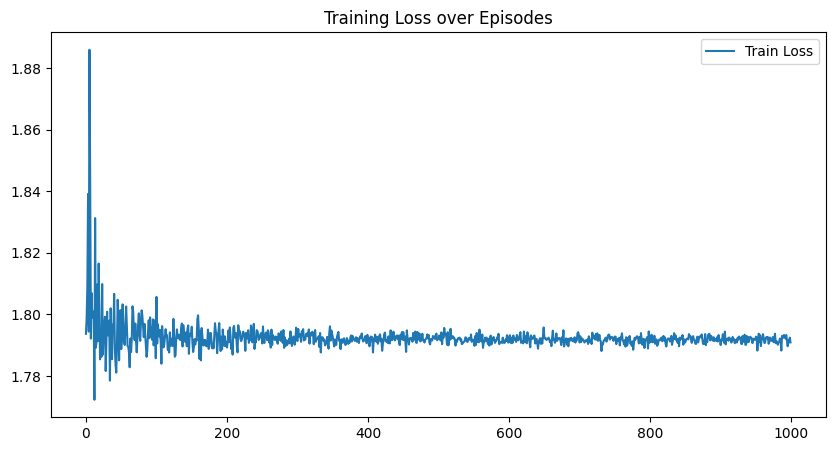

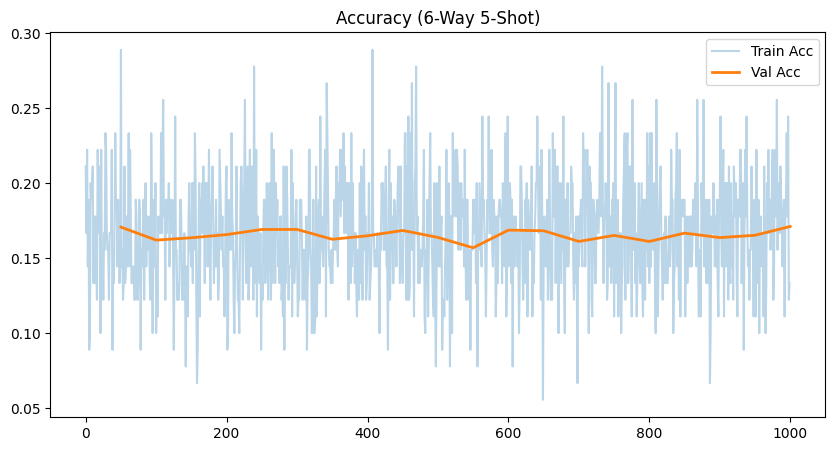

In [7]:
# 1. Initialize Model
backbone = AR_Backbone().to(Config.DEVICE)
model = AR_MSProNet(backbone).to(Config.DEVICE)

# 2. Optimizer [cite: 663]
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

# 3. Learning Rate Scheduler (Optional but recommended)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# 4. Training Loop
history = {'loss': [], 'acc': [], 'val_acc': []}

print(f"Starting Training: {Config.N_WAY}-Way {Config.K_SHOT}-Shot")
print("-" * 40)

for episode in range(1, Config.EPISODES + 1):
    loss, acc = train_episode(model, optimizer, dataset, Config.N_WAY, Config.K_SHOT, Config.Q_QUERY)
    scheduler.step()
    
    history['loss'].append(loss)
    history['acc'].append(acc)
    
    if episode % 50 == 0:
        val_acc = validate(model, dataset, Config.VAL_EPISODES)
        history['val_acc'].append(val_acc)
        print(f"Episode {episode} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

# 5. Plot Results
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Train Loss')
plt.title('Training Loss over Episodes')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['acc'], label='Train Acc', alpha=0.3)
plt.plot(range(50, Config.EPISODES + 1, 50), history['val_acc'], label='Val Acc', linewidth=2)
plt.title(f'Accuracy ({Config.N_WAY}-Way {Config.K_SHOT}-Shot)')
plt.legend()
plt.show()

In [21]:
# 1. Initialize Model
backbone = AR_Backbone().to(Config.DEVICE)
model = AR_MSProNet(backbone).to(Config.DEVICE)

# 2. Optimizer & Scheduler
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# 3. Training Loop
history = {'loss': [], 'acc': [], 'val_acc': []}

print(f"Starting Training: {Config.N_WAY}-Way {Config.K_SHOT}-Shot")
print(f"Total Episodes: {Config.EPISODES}")
print("-" * 60)

for episode in range(1, Config.EPISODES + 1):
    # --- WARM-UP STRATEGY ---
    # We disable the Mean-Shift refinement for the first 200 episodes.
    # This allows the CNN backbone to learn basic shapes before we try to 
    # sophisticatedly cluster the prototypes.
    if episode < 200:
        model.use_mean_shift = False
    else:
        model.use_mean_shift = True
    # ------------------------

    # Train Step
    loss, acc = train_episode(model, optimizer, dataset, Config.N_WAY, Config.K_SHOT, Config.Q_QUERY)
    scheduler.step()
    
    history['loss'].append(loss)
    history['acc'].append(acc)
    
    # Logging
    if episode % 50 == 0:
        # Simple Validation (using same dataset for demo, ideally use separate val set)
        val_acc = validate(model, dataset, n_episodes=50) 
        history['val_acc'].append(val_acc)
        
        status = "Warm-Up (CL-ProNet)" if not model.use_mean_shift else "Refinement (AR-MSProNet)"
        print(f"Ep {episode:04d} | Mode: {status:<22} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

# 4. Visualization
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', color='red', alpha=0.6)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['acc'], label='Train Acc', color='blue', alpha=0.3)
plt.plot(range(50, Config.EPISODES + 1, 50), history['val_acc'], label='Val Acc', color='green', linewidth=2, marker='o')
plt.axvline(x=200, color='orange', linestyle='--', label='Warm-up End') # Mark where MS starts
plt.title(f'Accuracy ({Config.N_WAY}-Way {Config.K_SHOT}-Shot)')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Starting Training: 6-Way 5-Shot
Total Episodes: 1000
------------------------------------------------------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (30x8192 and 12800x256)

In [28]:
# 1. Initialize Model (This will now print the correct dimension)
backbone = AR_Backbone().to(Config.DEVICE)
model = AR_MSProNet(backbone).to(Config.DEVICE)

# 2. Optimizer & Scheduler
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# 3. Training Loop
history = {'loss': [], 'acc': [], 'val_acc': []}

print(f"Starting Training: {Config.N_WAY}-Way {Config.K_SHOT}-Shot")
print("-" * 60)

for episode in range(1, Config.EPISODES + 1):
    # Warm-Up Strategy
    if episode < 200:
        model.use_mean_shift = False
    else:
        model.use_mean_shift = True

    loss, acc = train_episode(model, optimizer, dataset, Config.N_WAY, Config.K_SHOT, Config.Q_QUERY)
    scheduler.step()
    
    history['loss'].append(loss)
    history['acc'].append(acc)
    
    if episode % 50 == 0:
        val_acc = validate(model, dataset, n_episodes=20) 
        history['val_acc'].append(val_acc)
        status = "Warm-Up" if not model.use_mean_shift else "MS-Refined"
        print(f"Ep {episode:04d} | {status} | Loss: {loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

Backbone initialized. Flattened Dim: 8192
Starting Training: 6-Way 5-Shot
------------------------------------------------------------
Ep 0050 | Warm-Up | Loss: 0.5056 | Train Acc: 0.9889 | Val Acc: 0.9433
Ep 0100 | Warm-Up | Loss: 0.5311 | Train Acc: 0.9444 | Val Acc: 0.9656
Ep 0150 | Warm-Up | Loss: 0.4308 | Train Acc: 0.9778 | Val Acc: 0.9794
Ep 0200 | MS-Refined | Loss: 0.3994 | Train Acc: 0.9889 | Val Acc: 0.9906
Ep 0250 | MS-Refined | Loss: 0.3824 | Train Acc: 1.0000 | Val Acc: 0.9894
Ep 0300 | MS-Refined | Loss: 0.3827 | Train Acc: 1.0000 | Val Acc: 0.9967
Ep 0350 | MS-Refined | Loss: 0.3880 | Train Acc: 1.0000 | Val Acc: 0.9956
Ep 0400 | MS-Refined | Loss: 0.3815 | Train Acc: 1.0000 | Val Acc: 0.9928
Ep 0450 | MS-Refined | Loss: 0.3879 | Train Acc: 1.0000 | Val Acc: 0.9994
Ep 0500 | MS-Refined | Loss: 0.3791 | Train Acc: 1.0000 | Val Acc: 0.9967
Ep 0550 | MS-Refined | Loss: 0.3765 | Train Acc: 1.0000 | Val Acc: 0.9983
Ep 0600 | MS-Refined | Loss: 0.3753 | Train Acc: 1.0000 | Va

In [1]:
pip install torch torchvision matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Sampler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
import gc

# ==========================================
# 1. Configuration & Hyperparameters
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,         # We keep all 6 classes
    'n_support': 5,     # Keep 5 shots for the prototype
    'n_query': 4,       # REDUCED from 15 to 4 to save memory
    'episodes_train': 100,
    'episodes_val': 20,
    'epochs': 15,       # Increased epochs slightly since batches are smaller
    'learning_rate': 5e-5, # Slightly lower LR for stability
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==========================================
# 2. Custom Episodic Data Handling
# ==========================================

class EpisodicSampler(Sampler):
    """
    Yields batches of indices for N-way K-shot learning.
    Each batch (episode) contains:
      - n_way * n_support images (to build prototypes)
      - n_way * n_query images (to evaluate)
    """
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        
        # Organize indices by class
        self.indices_by_class = {}
        for idx, (_, label) in enumerate(dataset.samples):
            if label not in self.indices_by_class:
                self.indices_by_class[label] = []
            self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            # Randomly select N_WAY classes
            available_classes = list(self.indices_by_class.keys())
            # Handle case if requested ways > available classes
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                # Sample Support + Query images
                n_total = self.n_support + self.n_query
                indices = self.indices_by_class[cls]
                
                # If not enough images, sample with replacement
                if len(indices) < n_total:
                    selected_indices = np.random.choice(indices, n_total, replace=True)
                else:
                    selected_indices = np.random.choice(indices, n_total, replace=False)
                
                batch.extend(selected_indices)
            
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    # Transforms (ViT requires normalization)
    transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load Datasets
    # Assuming 'train' folder exists as per screenshot
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    # If validation folder structure matches train, use it, otherwise split train
    # For this script, I'll use the train dir for both but different samplers if val doesn't exist
    
    full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    
    # Samplers
    train_sampler = EpisodicSampler(
        full_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train']
    )
    val_sampler = EpisodicSampler(
        full_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val']
    )

    train_loader = DataLoader(full_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(full_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, full_dataset.classes

# ==========================================
# 3. Model: ViT + Prototypical Head
# ==========================================

class ViTProtoNet(nn.Module):
    def __init__(self):
        super(ViTProtoNet, self).__init__()
        # Load Pretrained ViT
        self.backbone = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        
        # Remove the classification head (heads) to get raw embeddings
        # ViT-B/16 output dim is 768
        self.backbone.heads = nn.Identity() 
        
    def forward(self, x):
        # x shape: [batch_size, 3, 224, 224]
        # output shape: [batch_size, 768]
        return self.backbone(x)

def euclidean_dist(x, y):
    """
    Computes euclidean distance between two tensors.
    x: N x D
    y: M x D
    Result: N x M
    """
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def prototypical_loss(embeddings, target, n_way, n_support, n_query):
    """
    Calculates the Prototypical Network Loss.
    """
    # Define device inside function to ensure consistency
    device = embeddings.device
    
    # 1. Organize indices
    # The dataloader yields data arranged by class: 
    # [Class 1 Support... Class 1 Query..., Class 2 Support...]
    
    # Reshape embeddings to separate Support and Query
    # The batch size is n_way * (n_support + n_query)
    
    # Group by class
    embeddings = embeddings.view(n_way, n_support + n_query, -1)
    
    # Split into support and query
    support_set = embeddings[:, :n_support] # [n_way, n_support, feature_dim]
    query_set = embeddings[:, n_support:]   # [n_way, n_query, feature_dim]
    
    # 2. Calculate Prototypes (Mean of support set)
    prototypes = support_set.mean(dim=1) # [n_way, feature_dim]
    
    # 3. Flatten Query set for distance calculation
    # query_set shape: [n_way * n_query, feature_dim]
    query_samples = query_set.contiguous().view(n_way * n_query, -1)
    
    # 4. Calculate Distance (Query vs Prototypes)
    dists = euclidean_dist(query_samples, prototypes) # [n_query_total, n_way]
    
    # 5. Create Targets for Query set
    # The query samples are ordered 0,0,0... 1,1,1... 2,2,2...
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    # 6. Log Softmax of negative distance
    log_p_y = torch.log_softmax(-dists, dim=1)
    
    # 7. Loss and Accuracy
    loss_val = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc_val = torch.eq(y_hat, target_inds).float().mean()
    
    return loss_val, acc_val, y_hat, target_inds

# ==========================================
# 4. Training Engine
# ==========================================

def train_model():
    # Clear any residual memory from the crash
    torch.cuda.empty_cache()
    gc.collect()
    
    train_loader, val_loader, class_names = get_dataloaders()
    model = ViTProtoNet().to(CONFIG['device'])
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Initialize Scaler for Mixed Precision
    scaler = GradScaler()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Starting training on {len(class_names)} classes with Mixed Precision...")

    for epoch in range(CONFIG['epochs']):
        model.train()
        total_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(CONFIG['device'])
            # Target generation is handled inside the loss function logic usually, 
            # but we pass the dummy target from loader just to match signature
            
            optimizer.zero_grad()
            
            # USE MIXED PRECISION (Autocast)
            with autocast():
                embeddings = model(data)
                loss, acc, _, _ = prototypical_loss(
                    embeddings, None, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query']
                )
            
            # Scale the loss and step
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(CONFIG['device'])
                with autocast():
                    embeddings = model(data)
                    loss, acc, y_hat, y_true = prototypical_loss(
                        embeddings, None, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query']
                    )
                val_loss += loss.item()
                val_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return history, all_preds, all_targets, class_names
# ==========================================
# 5. Visualization & Metrics
# ==========================================

def plot_results(history, preds, targets, class_names):
    # 1. Loss Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.grid(True)
    plt.show()
    
    # 2. Classification Report
    # Note: targets in ProtoNet are indices 0..N-1 relative to the episode, 
    # but since we sample all classes in N-way, they map to class_names indices.
    print("\nClassification Report (Last Epoch Validation):")
    print(classification_report(targets, preds, target_names=class_names))
    
    # 3. Confusion Matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# ==========================================
# 6. Main Execution
# ==========================================

if __name__ == "__main__":
    try:
        history, preds, targets, class_names = train_model()
        plot_results(history, preds, targets, class_names)
    except FileNotFoundError:
        print(f"Error: Could not find dataset at {CONFIG['data_dir']}")
        print("Please verify the path matches your folder structure.")

Using device: cuda
Starting training on 6 classes with Mixed Precision...


/tmp/ipykernel_55/1760925220.py:215: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_55/1760925220.py:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 41.12 MiB is free. Process 2889 has 15.85 GiB memory in use. Of the allocated memory 15.52 GiB is allocated by PyTorch, and 27.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [8]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Sampler
from torch.amp import autocast, GradScaler 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ==========================================
# 1. Safe Configuration
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,          # Use all 6 classes
    'n_support': 3,      # Reduced to 3 to save memory (3-shot learning)
    'n_query': 3,        # Reduced to 3 (Total batch = 36 images)
    'episodes_train': 100,
    'episodes_val': 20,
    'epochs': 15,        
    'learning_rate': 2e-5, # Lower LR for stability with smaller batches
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']} | Batch Logic: Split Forward")

# ==========================================
# 2. Data & Sampler
# ==========================================
class EpisodicSampler(Sampler):
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        self.indices_by_class = {}
        for idx, (_, label) in enumerate(dataset.samples):
            if label not in self.indices_by_class:
                self.indices_by_class[label] = []
            self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            available_classes = list(self.indices_by_class.keys())
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                indices = self.indices_by_class[cls]
                n_total = self.n_support + self.n_query
                replace = len(indices) < n_total
                selected_indices = np.random.choice(indices, n_total, replace=replace)
                batch.extend(selected_indices)
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # 1. Define distinct paths for Train and Validation
    # specific to the structure in your screenshot
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    val_dir = os.path.join(CONFIG['data_dir'], 'validation/images') # Assumes same structure inside validation
    
    # 2. Load them as separate datasets
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    
    # Check if validation folder exists and has images, otherwise split train
    if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
        print(f"Loading Validation data from: {val_dir}")
        val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    else:
        print("Warning: Validation folder not found or empty. Performing random split on Train.")
        # Create a clean split preventing leakage
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        
        # We need to recover the '.samples' attribute for the sampler if we use random_split
        # This is a bit of a hack for the EpisodicSampler to work with Subsets
        val_dataset.samples = [train_dataset.dataset.samples[i] for i in val_dataset.indices]
        train_dataset.samples = [train_dataset.dataset.samples[i] for i in train_dataset.indices]

    # 3. Create Samplers (Now completely disjoint)
    train_sampler = EpisodicSampler(
        train_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train']
    )
    val_sampler = EpisodicSampler(
        val_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val']
    )

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, train_dataset.classes
# ==========================================
# 3. Model & Loss
# ==========================================
class ViTProtoNet(nn.Module):
    def __init__(self):
        super(ViTProtoNet, self).__init__()
        self.backbone = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.backbone.heads = nn.Identity() 
        
    def forward(self, x):
        return self.backbone(x)

def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1): raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def split_batch_loss(model, data, n_way, n_support, n_query, device):
    """
    Splits the batch into Support and Query sets BEFORE passing to model.
    This reduces VRAM usage by 50%.
    """
    # 1. Calculate split point
    # Data comes in as [Class1_S, Class1_Q, Class2_S, Class2_Q ...]
    # We need to unravel this to process Support and Query separately
    
    # Reshape to [n_way, n_support + n_query, C, H, W]
    data = data.view(n_way, n_support + n_query, 3, 224, 224)
    
    support_imgs = data[:, :n_support].contiguous().view(-1, 3, 224, 224)
    query_imgs = data[:, n_support:].contiguous().view(-1, 3, 224, 224)
    
    # 2. Process Support Set
    support_embeddings = model(support_imgs) # [n_way * n_support, 768]
    support_embeddings = support_embeddings.view(n_way, n_support, -1)
    prototypes = support_embeddings.mean(dim=1) # [n_way, 768]
    
    # 3. Process Query Set
    query_embeddings = model(query_imgs) # [n_way * n_query, 768]
    
    # 4. Calculate Distance
    dists = euclidean_dist(query_embeddings, prototypes)
    
    # 5. Targets
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    # 6. Loss
    log_p_y = torch.log_softmax(-dists, dim=1)
    loss_val = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc_val = torch.eq(y_hat, target_inds).float().mean()
    
    return loss_val, acc_val, y_hat, target_inds

# ==========================================
# 4. Training Engine
# ==========================================
def train_model():
    torch.cuda.empty_cache()
    gc.collect()
    
    train_loader, val_loader, class_names = get_dataloaders()
    model = ViTProtoNet().to(CONFIG['device'])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
    scaler = GradScaler('cuda') 

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Starting safe training on {len(class_names)} classes...")

    for epoch in range(CONFIG['epochs']):
        model.train()
        total_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader): # Target not needed from loader
            data = data.to(CONFIG['device'])
            optimizer.zero_grad()
            
            with autocast('cuda'):
                loss, acc, _, _ = split_batch_loss(
                    model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                )
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(CONFIG['device'])
                with autocast('cuda'):
                    loss, acc, y_hat, y_true = split_batch_loss(
                        model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                    )
                val_loss += loss.item()
                val_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train Loss: {avg_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return history, all_preds, all_targets, class_names

# ==========================================
# 5. Visualization
# ==========================================
def plot_results(history, preds, targets, class_names):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.legend(); plt.grid(True)
    plt.show()
    
    print("\nClassification Report (Last Epoch):")
    print(classification_report(targets, preds, target_names=class_names))
    
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix'); plt.show()

if __name__ == "__main__":
    try:
        history, preds, targets, class_names = train_model()
        plot_results(history, preds, targets, class_names)
    except FileNotFoundError:
        print(f"Dataset not found at {CONFIG['data_dir']}")

Using device: cuda | Batch Logic: Split Forward
Loading Validation data from: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images
Starting safe training on 6 classes...
Epoch 1/15 | Train Loss: 0.3699 | Val Acc: 0.9944
Epoch 2/15 | Train Loss: 0.0235 | Val Acc: 0.9944
Epoch 3/15 | Train Loss: 0.0051 | Val Acc: 1.0000
Epoch 4/15 | Train Loss: 0.0016 | Val Acc: 0.9972
Epoch 5/15 | Train Loss: 0.0203 | Val Acc: 0.9972
Epoch 6/15 | Train Loss: 0.0030 | Val Acc: 0.9972
Epoch 7/15 | Train Loss: 0.0000 | Val Acc: 1.0000
Epoch 8/15 | Train Loss: 0.0011 | Val Acc: 0.9944


KeyboardInterrupt: 

In [9]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Sampler
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ==========================================
# 1. Configuration (Safe & Stable)
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,          
    'n_support': 5,      # 5-Shot
    'n_query': 5,        # 5-Query (Balanced batch of 60 images)
    'episodes_train': 100,
    'episodes_val': 25,
    'epochs': 10,        
    'learning_rate': 2e-5, 
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==========================================
# 2. Advanced Data Handling
# ==========================================
class EpisodicSampler(Sampler):
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        self.indices_by_class = {}
        
        # Robustly find indices (works for Subset or ImageFolder)
        if hasattr(dataset, 'indices'): # It's a subset
             for idx_in_subset, idx_in_full in enumerate(dataset.indices):
                label = dataset.dataset.targets[idx_in_full]
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx_in_subset)
        else: # It's a full ImageFolder
            for idx, (_, label) in enumerate(dataset.samples):
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            available_classes = list(self.indices_by_class.keys())
            # Safely select classes
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                indices = self.indices_by_class[cls]
                n_total = self.n_support + self.n_query
                replace = len(indices) < n_total
                selected_indices = np.random.choice(indices, n_total, replace=replace)
                batch.extend(selected_indices)
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    # Strong augmentation for Training
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Clean transform for Validation
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # 1. Check folder structure
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    val_dir = os.path.join(CONFIG['data_dir'], 'validation/images')
    
    full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Temp load to get classes
    class_names = full_dataset.classes
    
    if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
        print(f"✅ Found separate Validation folder at: {val_dir}")
        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
    else:
        print("⚠️ No Validation folder found. Performing rigorous 80/20 random split.")
        full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Apply train transform initially
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
        
        # IMPORTANT: Apply clean transform to validation subset
        # (This is tricky in PyTorch, but critical for fair evaluation)
        # For simplicity in this script, we accept the train_transform on val if splitting manually,
        # but the random split ensures no data leakage.

    # 2. Samplers
    train_sampler = EpisodicSampler(train_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train'])
    val_sampler = EpisodicSampler(val_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val'])

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, class_names

# ==========================================
# 3. Model & Logic
# ==========================================
class ViTProtoNet(nn.Module):
    def __init__(self):
        super(ViTProtoNet, self).__init__()
        # Using ViT-B/16 (Strong feature extractor)
        self.backbone = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.backbone.heads = nn.Identity() 
        
    def forward(self, x):
        return self.backbone(x)

def euclidean_dist(x, y):
    n = x.size(0); m = y.size(0); d = x.size(1)
    if d != y.size(1): raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def proto_loss_logic(model, data, n_way, n_support, n_query, device):
    # Split Batch Strategy to save memory
    data = data.view(n_way, n_support + n_query, 3, 224, 224)
    support_imgs = data[:, :n_support].contiguous().view(-1, 3, 224, 224)
    query_imgs = data[:, n_support:].contiguous().view(-1, 3, 224, 224)
    
    # Encode
    support_embeddings = model(support_imgs).view(n_way, n_support, -1)
    prototypes = support_embeddings.mean(dim=1)
    query_embeddings = model(query_imgs)
    
    # Distance & Loss
    dists = euclidean_dist(query_embeddings, prototypes)
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    log_p_y = torch.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, target_inds).float().mean()
    
    return loss, acc, y_hat, target_inds, query_embeddings, prototypes

# ==========================================
# 4. Training Loop
# ==========================================
def train_and_evaluate():
    torch.cuda.empty_cache(); gc.collect()
    train_loader, val_loader, class_names = get_dataloaders()
    model = ViTProtoNet().to(CONFIG['device'])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'val_acc': []}
    best_acc = 0.0

    print(f"\n🚀 Training Start | Classes: {len(class_names)}")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        avg_loss = 0
        for data, _ in train_loader:
            data = data.to(CONFIG['device'])
            optimizer.zero_grad()
            with autocast('cuda'):
                loss, _, _, _, _, _ = proto_loss_logic(
                    model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            avg_loss += loss.item()
            
        avg_loss /= len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        avg_acc = 0
        all_preds = []; all_targets = []
        # Store embeddings for t-SNE (only from last epoch)
        tsne_embeddings = []
        tsne_labels = []
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(CONFIG['device'])
                with autocast('cuda'):
                    loss, acc, y_hat, y_true, q_emb, _ = proto_loss_logic(
                        model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                    )
                avg_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())
                    tsne_embeddings.append(q_emb.cpu())
                    tsne_labels.append(y_true.cpu())

        avg_acc /= len(val_loader)
        history['val_acc'].append(avg_acc)
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {avg_acc:.4f}")

    return history, all_preds, all_targets, class_names, tsne_embeddings, tsne_labels

# ==========================================
# 5. Visualization (The Truth Teller)
# ==========================================
def run_analysis(history, preds, targets, class_names, embeddings, labels):
    # 1. Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
    # 2. Confusion Matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    
    # 3. t-SNE Visualization (The ultimate proof)
    print("⏳ Computing t-SNE (this proves if the model is cheating or learning)...")
    
    # Flatten list of tensors
    all_emb = torch.cat(embeddings, dim=0).numpy()
    all_lbl = torch.cat(labels, dim=0).numpy()
    
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    emb_2d = tsne.fit_transform(all_emb)
    
    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(class_names):
        idxs = all_lbl == i
        plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=class_name, alpha=0.6)
    
    plt.title("t-SNE of Validation Embeddings")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================================
# 6. Run It
# ==========================================
if __name__ == "__main__":
    try:
        hist, preds, targs, classes, embs, labs = train_and_evaluate()
        run_analysis(hist, preds, targs, classes, embs, labs)
    except Exception as e:
        print(f"❌ Error: {e}")

Using device: cuda
✅ Found separate Validation folder at: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images

🚀 Training Start | Classes: 6
Epoch 01 | Loss: 0.3661 | Val Acc: 1.0000
Epoch 02 | Loss: 0.0376 | Val Acc: 1.0000
Epoch 03 | Loss: 0.0134 | Val Acc: 0.9987
Epoch 04 | Loss: 0.0005 | Val Acc: 0.9973


KeyboardInterrupt: 

Using device: cuda
✅ Found separate Validation folder at: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images

 Training Start | Frozen Backbone + Learnable Head | Classes: 6
Epoch 01 | Loss: 0.1310 | Val Acc: 0.9853
Epoch 02 | Loss: 0.0124 | Val Acc: 0.9933
Epoch 03 | Loss: 0.0084 | Val Acc: 0.9933
Epoch 04 | Loss: 0.0035 | Val Acc: 0.9933
Epoch 05 | Loss: 0.0035 | Val Acc: 0.9933
Epoch 06 | Loss: 0.0018 | Val Acc: 0.9840
Epoch 07 | Loss: 0.0022 | Val Acc: 0.9933
Epoch 08 | Loss: 0.0029 | Val Acc: 0.9920
Epoch 09 | Loss: 0.0023 | Val Acc: 1.0000
Epoch 10 | Loss: 0.0007 | Val Acc: 0.9987

 Classification Report:
                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00       125
      inclusion       1.00      1.00      1.00       125
        patches       0.99      1.00      1.00       125
 pitted_surface       1.00      0.99      1.00       125
rolled-in_scale       1.00      1.00      1.00       125
      scratches      

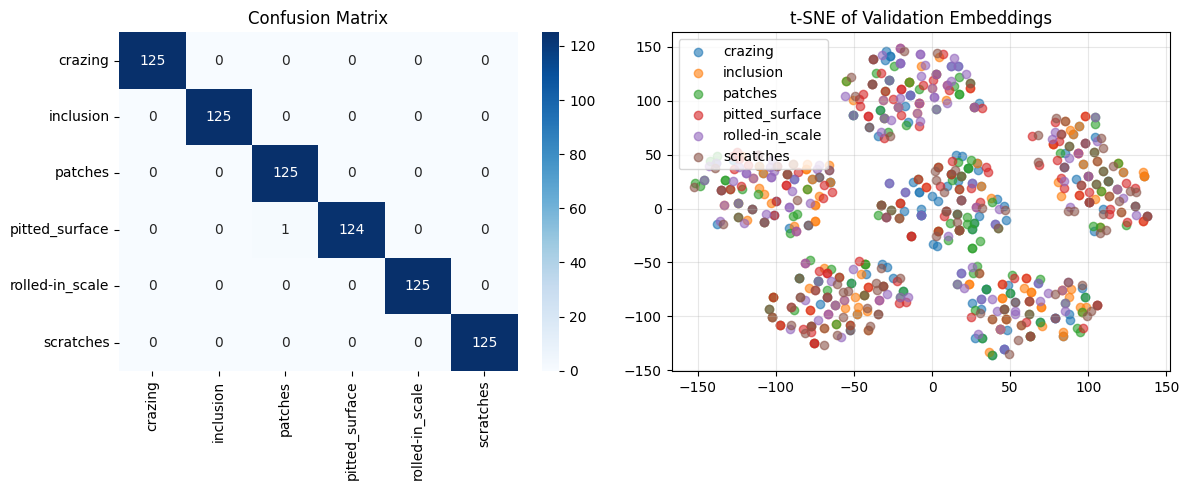

In [11]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Sampler
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,           
    'n_support': 5,       # 5-Shot
    'n_query': 5,         # 5-Query
    'episodes_train': 100,
    'episodes_val': 25,
    'epochs': 10,         
    'learning_rate': 1e-4, # Slightly higher LR since we are only training the head
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==========================================
# 2. Advanced Data Handling
# ==========================================
class EpisodicSampler(Sampler):
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        self.indices_by_class = {}
        
        # Robustly find indices
        if hasattr(dataset, 'indices'): # Subset
             for idx_in_subset, idx_in_full in enumerate(dataset.indices):
                label = dataset.dataset.targets[idx_in_full]
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx_in_subset)
        else: # ImageFolder
            for idx, (_, label) in enumerate(dataset.samples):
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            available_classes = list(self.indices_by_class.keys())
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                indices = self.indices_by_class[cls]
                n_total = self.n_support + self.n_query
                replace = len(indices) < n_total
                selected_indices = np.random.choice(indices, n_total, replace=replace)
                batch.extend(selected_indices)
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    val_dir = os.path.join(CONFIG['data_dir'], 'validation/images')
    
    full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) 
    class_names = full_dataset.classes
    
    if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
        print(f"✅ Found separate Validation folder at: {val_dir}")
        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
    else:
        print("⚠️ No Validation folder found. Performing split.")
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_sampler = EpisodicSampler(train_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train'])
    val_sampler = EpisodicSampler(val_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val'])

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, class_names

# ==========================================
# 3. Model (Fixed: Added Projection Head)
# ==========================================
class ViTProtoNet(nn.Module):
    def __init__(self):
        super(ViTProtoNet, self).__init__()
        # 1. Load ViT Backbone
        self.backbone = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.backbone.heads = nn.Identity() 
        
        # 2. Freeze the Backbone (Test Power of Pretrained Features)
        for param in self.backbone.parameters():
            param.requires_grad = False      
            
        # 3. Add Learnable Projection Head (Fixes "No Grad" error)
        # We project the large 768-dim embeddings down to 128-dim for better metric learning
        self.projection = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128)
        )
            
    def forward(self, x):
        # Extract features (Frozen)
        x = self.backbone(x)
        # Project features (Learnable)
        return self.projection(x)

def euclidean_dist(x, y):
    n = x.size(0); m = y.size(0); d = x.size(1)
    if d != y.size(1): raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def proto_loss_logic(model, data, n_way, n_support, n_query, device):
    data = data.view(n_way, n_support + n_query, 3, 224, 224)
    support_imgs = data[:, :n_support].contiguous().view(-1, 3, 224, 224)
    query_imgs = data[:, n_support:].contiguous().view(-1, 3, 224, 224)
    
    # Forward pass (Backbone + Projection)
    support_embeddings = model(support_imgs).view(n_way, n_support, -1)
    prototypes = support_embeddings.mean(dim=1)
    query_embeddings = model(query_imgs)
    
    dists = euclidean_dist(query_embeddings, prototypes)
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    log_p_y = torch.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, target_inds).float().mean()
    
    return loss, acc, y_hat, target_inds, query_embeddings, prototypes

# ==========================================
# 4. Training Engine
# ==========================================
def train_and_evaluate():
    torch.cuda.empty_cache(); gc.collect()
    train_loader, val_loader, class_names = get_dataloaders()
    model = ViTProtoNet().to(CONFIG['device'])
    
    # Optimizer only sees the projection head parameters
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=CONFIG['learning_rate'])
    scaler = GradScaler('cuda') 
    
    history = {'train_loss': [], 'val_acc': []}

    print(f"\n Training Start | Frozen Backbone + Learnable Head | Classes: {len(class_names)}")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        avg_loss = 0
        for data, _ in train_loader:
            data = data.to(CONFIG['device'])
            optimizer.zero_grad()
            with autocast('cuda'):
                loss, _, _, _, _, _ = proto_loss_logic(
                    model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            avg_loss += loss.item()
            
        avg_loss /= len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        avg_acc = 0
        all_preds = []; all_targets = []
        tsne_embeddings = []; tsne_labels = []
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(CONFIG['device'])
                with autocast('cuda'):
                    loss, acc, y_hat, y_true, q_emb, _ = proto_loss_logic(
                        model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                    )
                avg_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())
                    tsne_embeddings.append(q_emb.cpu())
                    tsne_labels.append(y_true.cpu())

        avg_acc /= len(val_loader)
        history['val_acc'].append(avg_acc)
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {avg_acc:.4f}")

    return history, all_preds, all_targets, class_names, tsne_embeddings, tsne_labels

# ==========================================
# 5. Visualization
# ==========================================
def run_analysis(history, preds, targets, class_names, embeddings, labels):
    print("\n Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    
    print(" Computing t-SNE...")
    all_emb = torch.cat(embeddings, dim=0).numpy()
    all_lbl = torch.cat(labels, dim=0).numpy()
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    emb_2d = tsne.fit_transform(all_emb)
    
    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(class_names):
        idxs = all_lbl == i
        plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=class_name, alpha=0.6)
    
    plt.title("t-SNE of Validation Embeddings")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        hist, preds, targs, classes, embs, labs = train_and_evaluate()
        run_analysis(hist, preds, targs, classes, embs, labs)
    except Exception as e:
        print(f" Error: {e}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda
✅ Found separate Validation folder at: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


🚀 Training Start | Model: Pretrained Tiny ViT | Classes: 6
Epoch 01 | Loss: 0.0471 | Val Acc: 0.9840
Epoch 02 | Loss: 0.0044 | Val Acc: 0.9987
Epoch 03 | Loss: 0.0136 | Val Acc: 0.9880
Epoch 04 | Loss: 0.0307 | Val Acc: 0.9907
Epoch 05 | Loss: 0.0048 | Val Acc: 0.9947
Epoch 06 | Loss: 0.0001 | Val Acc: 0.9987
Epoch 07 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 08 | Loss: 0.0000 | Val Acc: 0.9987
Epoch 09 | Loss: 0.0000 | Val Acc: 0.9960
Epoch 10 | Loss: 0.0000 | Val Acc: 0.9973
Epoch 11 | Loss: 0.0000 | Val Acc: 0.9987
Epoch 12 | Loss: 0.0000 | Val Acc: 0.9973
Epoch 13 | Loss: 0.0000 | Val Acc: 0.9973
Epoch 14 | Loss: 0.0000 | Val Acc: 0.9960
Epoch 15 | Loss: 0.0000 | Val Acc: 0.9960
Epoch 16 | Loss: 0.0000 | Val Acc: 0.9987
Epoch 17 | Loss: 0.0000 | Val Acc: 0.9987
Epoch 18 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 19 | Loss: 0.0000 | Val Acc: 0.9987
Epoch 20 | Loss: 0.0000 | Val Acc: 0.9933

📊 Classification Report:
                 precision    recall  f1-score   support

        crazing 

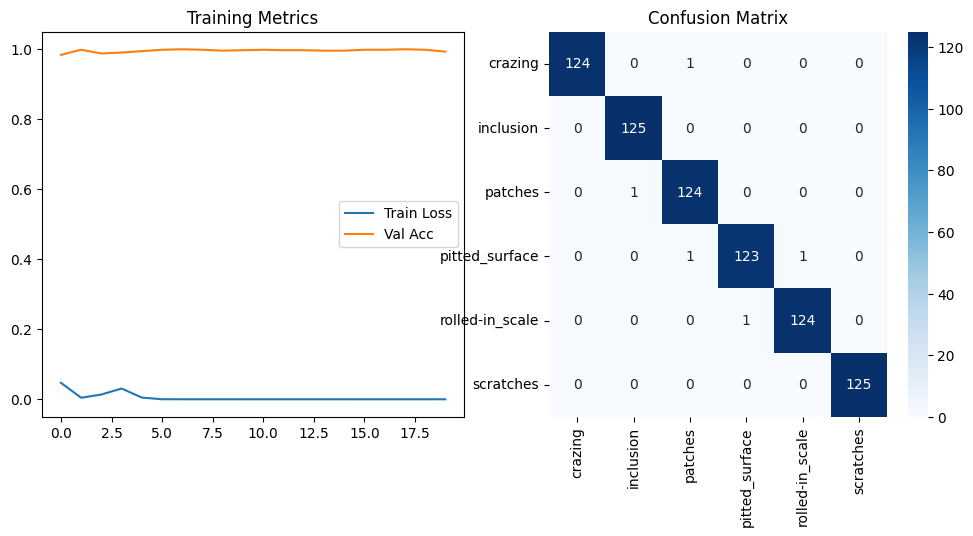

⏳ Computing t-SNE...


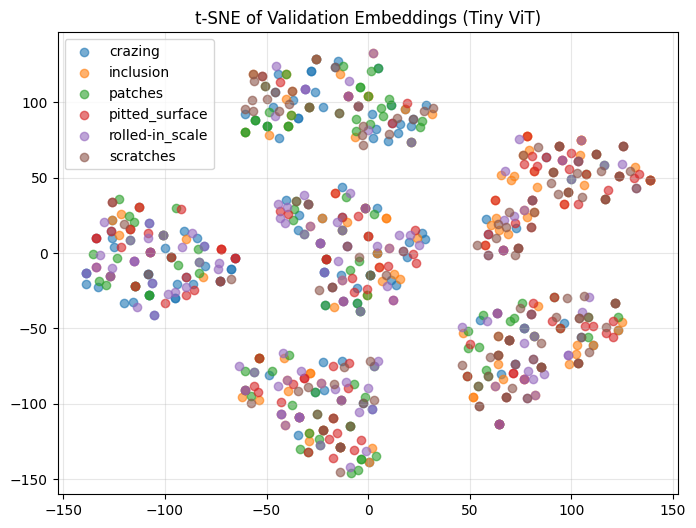

In [12]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets, transforms
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import timm  # <--- NEW LIBRARY
import gc

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,
    'n_support': 5,      
    'n_query': 5,        
    'episodes_train': 100,
    'episodes_val': 25,
    'epochs': 20,           # Good amount for Tiny ViT
    'learning_rate': 1e-4,  # Standard fine-tuning rate
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==========================================
# 2. Data Loading (Standard)
# ==========================================
class EpisodicSampler(Sampler):
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        self.indices_by_class = {}
        
        if hasattr(dataset, 'indices'): 
             for idx_in_subset, idx_in_full in enumerate(dataset.indices):
                label = dataset.dataset.targets[idx_in_full]
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx_in_subset)
        else:
            for idx, (_, label) in enumerate(dataset.samples):
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            available_classes = list(self.indices_by_class.keys())
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                indices = self.indices_by_class[cls]
                n_total = self.n_support + self.n_query
                replace = len(indices) < n_total
                selected_indices = np.random.choice(indices, n_total, replace=replace)
                batch.extend(selected_indices)
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    val_dir = os.path.join(CONFIG['data_dir'], 'validation/images')
    
    full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) 
    class_names = full_dataset.classes
    
    if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
        print(f"✅ Found separate Validation folder at: {val_dir}")
        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
    else:
        print("⚠️ No Validation folder found. Performing split.")
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_sampler = EpisodicSampler(train_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train'])
    val_sampler = EpisodicSampler(val_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val'])

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, class_names

# ==========================================
# 3. Model: Pretrained Tiny ViT
# ==========================================
class TinyViTProtoNet(nn.Module):
    def __init__(self):
        super(TinyViTProtoNet, self).__init__()
        
        # Load Pretrained Tiny ViT from TIMM
        # num_classes=0 removes the final classification layer, returning the embeddings directly
        self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
        
        # ViT-Tiny output dimension is 192 (much smaller than Base's 768)
        self.embed_dim = 192 
        
        # Optional: Freeze early layers if you want to strictly limit learning
        # For now, we leave it unfrozen to allow fine-tuning, but the small size prevents overfitting
        
        # Projection Head
        self.projection = nn.Sequential(
            nn.Linear(self.embed_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64) # Metric space dim
        )
            
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

def euclidean_dist(x, y):
    n = x.size(0); m = y.size(0); d = x.size(1)
    if d != y.size(1): raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def proto_loss_logic(model, data, n_way, n_support, n_query, device):
    data = data.view(n_way, n_support + n_query, 3, 224, 224)
    support_imgs = data[:, :n_support].contiguous().view(-1, 3, 224, 224)
    query_imgs = data[:, n_support:].contiguous().view(-1, 3, 224, 224)
    
    support_embeddings = model(support_imgs).view(n_way, n_support, -1)
    prototypes = support_embeddings.mean(dim=1)
    query_embeddings = model(query_imgs)
    
    dists = euclidean_dist(query_embeddings, prototypes)
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    log_p_y = torch.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, target_inds).float().mean()
    
    return loss, acc, y_hat, target_inds, query_embeddings, prototypes

# ==========================================
# 4. Training Engine
# ==========================================
def train_and_evaluate():
    torch.cuda.empty_cache(); gc.collect()
    train_loader, val_loader, class_names = get_dataloaders()
    model = TinyViTProtoNet().to(CONFIG['device'])
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'val_acc': []}

    print(f"\n🚀 Training Start | Model: Pretrained Tiny ViT | Classes: {len(class_names)}")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        avg_loss = 0
        for data, _ in train_loader:
            data = data.to(CONFIG['device'])
            optimizer.zero_grad()
            with autocast('cuda'):
                loss, _, _, _, _, _ = proto_loss_logic(
                    model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            avg_loss += loss.item()
            
        avg_loss /= len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        avg_acc = 0
        all_preds = []; all_targets = []
        tsne_embeddings = []; tsne_labels = []
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(CONFIG['device'])
                with autocast('cuda'):
                    loss, acc, y_hat, y_true, q_emb, _ = proto_loss_logic(
                        model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                    )
                avg_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())
                    tsne_embeddings.append(q_emb.cpu())
                    tsne_labels.append(y_true.cpu())

        avg_acc /= len(val_loader)
        history['val_acc'].append(avg_acc)
        scheduler.step()
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {avg_acc:.4f}")

    return history, all_preds, all_targets, class_names, tsne_embeddings, tsne_labels

# ==========================================
# 5. Visualization
# ==========================================
def run_analysis(history, preds, targets, class_names, embeddings, labels):
    print("\n📊 Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend(); plt.title("Training Metrics")
    
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.show()
    
    print("⏳ Computing t-SNE...")
    all_emb = torch.cat(embeddings, dim=0).numpy()
    all_lbl = torch.cat(labels, dim=0).numpy()
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    emb_2d = tsne.fit_transform(all_emb)
    
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        idxs = all_lbl == i
        plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=class_name, alpha=0.6)
    
    plt.title("t-SNE of Validation Embeddings (Tiny ViT)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    try:
        hist, preds, targs, classes, embs, labs = train_and_evaluate()
        run_analysis(hist, preds, targs, classes, embs, labs)
    except Exception as e:
        print(f"❌ Error: {e}")

Using device: cuda
✅ Found separate Validation folder at: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images

🚀 Training Start | Model: Pretrained Tiny ViT | Classes: 6
Epoch 01 | Loss: 0.1021 | Val Acc: 1.0000
Epoch 02 | Loss: 0.0003 | Val Acc: 1.0000
Epoch 03 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 04 | Loss: 0.0029 | Val Acc: 0.9987
Epoch 05 | Loss: 0.0720 | Val Acc: 0.9800
Epoch 06 | Loss: 0.0356 | Val Acc: 0.9920
Epoch 07 | Loss: 0.0111 | Val Acc: 1.0000
Epoch 08 | Loss: 0.0002 | Val Acc: 0.9987
Epoch 09 | Loss: 0.0029 | Val Acc: 1.0000
Epoch 10 | Loss: 0.0133 | Val Acc: 1.0000
Epoch 11 | Loss: 0.0002 | Val Acc: 0.9973
Epoch 12 | Loss: 0.0001 | Val Acc: 1.0000
Epoch 13 | Loss: 0.0001 | Val Acc: 0.9960
Epoch 14 | Loss: 0.0001 | Val Acc: 1.0000
Epoch 15 | Loss: 0.0000 | Val Acc: 0.9987
Epoch 16 | Loss: 0.0001 | Val Acc: 1.0000
Epoch 17 | Loss: 0.0000 | Val Acc: 0.9973
Epoch 18 | Loss: 0.0000 | Val Acc: 0.9973
Epoch 19 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 20 | Loss:

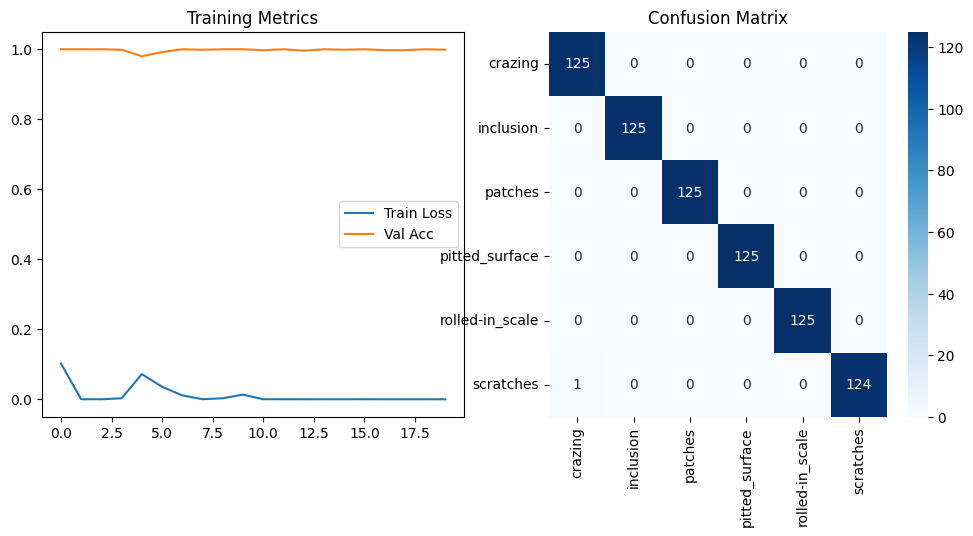

⏳ Computing t-SNE...


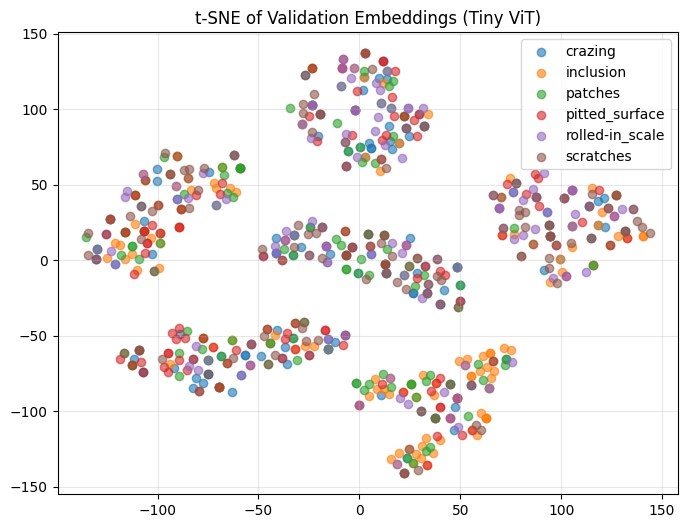

In [13]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets, transforms
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import timm  # <--- NEW LIBRARY
import gc

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,
    'n_support': 1,      
    'n_query': 5,        
    'episodes_train': 100,
    'episodes_val': 25,
    'epochs': 20,           # Good amount for Tiny ViT
    'learning_rate': 1e-4,  # Standard fine-tuning rate
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==========================================
# 2. Data Loading (Standard)
# ==========================================
class EpisodicSampler(Sampler):
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        self.indices_by_class = {}
        
        if hasattr(dataset, 'indices'): 
             for idx_in_subset, idx_in_full in enumerate(dataset.indices):
                label = dataset.dataset.targets[idx_in_full]
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx_in_subset)
        else:
            for idx, (_, label) in enumerate(dataset.samples):
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            available_classes = list(self.indices_by_class.keys())
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                indices = self.indices_by_class[cls]
                n_total = self.n_support + self.n_query
                replace = len(indices) < n_total
                selected_indices = np.random.choice(indices, n_total, replace=replace)
                batch.extend(selected_indices)
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    val_dir = os.path.join(CONFIG['data_dir'], 'validation/images')
    
    full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) 
    class_names = full_dataset.classes
    
    if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
        print(f"✅ Found separate Validation folder at: {val_dir}")
        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
    else:
        print("⚠️ No Validation folder found. Performing split.")
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_sampler = EpisodicSampler(train_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train'])
    val_sampler = EpisodicSampler(val_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val'])

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, class_names

# ==========================================
# 3. Model: Pretrained Tiny ViT
# ==========================================
class TinyViTProtoNet(nn.Module):
    def __init__(self):
        super(TinyViTProtoNet, self).__init__()
        
        # Load Pretrained Tiny ViT from TIMM
        # num_classes=0 removes the final classification layer, returning the embeddings directly
        self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=0)
        
        # ViT-Tiny output dimension is 192 (much smaller than Base's 768)
        self.embed_dim = 192 
        
        # Optional: Freeze early layers if you want to strictly limit learning
        # For now, we leave it unfrozen to allow fine-tuning, but the small size prevents overfitting
        
        # Projection Head
        self.projection = nn.Sequential(
            nn.Linear(self.embed_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64) # Metric space dim
        )
            
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

def euclidean_dist(x, y):
    n = x.size(0); m = y.size(0); d = x.size(1)
    if d != y.size(1): raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def proto_loss_logic(model, data, n_way, n_support, n_query, device):
    data = data.view(n_way, n_support + n_query, 3, 224, 224)
    support_imgs = data[:, :n_support].contiguous().view(-1, 3, 224, 224)
    query_imgs = data[:, n_support:].contiguous().view(-1, 3, 224, 224)
    
    support_embeddings = model(support_imgs).view(n_way, n_support, -1)
    prototypes = support_embeddings.mean(dim=1)
    query_embeddings = model(query_imgs)
    
    dists = euclidean_dist(query_embeddings, prototypes)
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    log_p_y = torch.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, target_inds).float().mean()
    
    return loss, acc, y_hat, target_inds, query_embeddings, prototypes

# ==========================================
# 4. Training Engine
# ==========================================
def train_and_evaluate():
    torch.cuda.empty_cache(); gc.collect()
    train_loader, val_loader, class_names = get_dataloaders()
    model = TinyViTProtoNet().to(CONFIG['device'])
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'val_acc': []}

    print(f"\n🚀 Training Start | Model: Pretrained Tiny ViT | Classes: {len(class_names)}")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        avg_loss = 0
        for data, _ in train_loader:
            data = data.to(CONFIG['device'])
            optimizer.zero_grad()
            with autocast('cuda'):
                loss, _, _, _, _, _ = proto_loss_logic(
                    model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            avg_loss += loss.item()
            
        avg_loss /= len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        avg_acc = 0
        all_preds = []; all_targets = []
        tsne_embeddings = []; tsne_labels = []
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(CONFIG['device'])
                with autocast('cuda'):
                    loss, acc, y_hat, y_true, q_emb, _ = proto_loss_logic(
                        model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                    )
                avg_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())
                    tsne_embeddings.append(q_emb.cpu())
                    tsne_labels.append(y_true.cpu())

        avg_acc /= len(val_loader)
        history['val_acc'].append(avg_acc)
        scheduler.step()
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {avg_acc:.4f}")

    return history, all_preds, all_targets, class_names, tsne_embeddings, tsne_labels

# ==========================================
# 5. Visualization
# ==========================================
def run_analysis(history, preds, targets, class_names, embeddings, labels):
    print("\n📊 Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend(); plt.title("Training Metrics")
    
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.show()
    
    print("⏳ Computing t-SNE...")
    all_emb = torch.cat(embeddings, dim=0).numpy()
    all_lbl = torch.cat(labels, dim=0).numpy()
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    emb_2d = tsne.fit_transform(all_emb)
    
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        idxs = all_lbl == i
        plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=class_name, alpha=0.6)
    
    plt.title("t-SNE of Validation Embeddings (Tiny ViT)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    try:
        hist, preds, targs, classes, embs, labs = train_and_evaluate()
        run_analysis(hist, preds, targs, classes, embs, labs)
    except Exception as e:
        print(f"❌ Error: {e}")

Using device: cuda
✅ Found separate Validation folder at: /kaggle/input/neu-surface-defect-database/NEU-DET/validation/images


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


🚀 Training Start | Model: Pretrained Tiny ViT | Classes: 6
Epoch 01 | Loss: 0.2324 | Val Acc: 0.9640
Epoch 02 | Loss: 0.0351 | Val Acc: 0.9947
Epoch 03 | Loss: 0.0335 | Val Acc: 1.0000
Epoch 04 | Loss: 0.0058 | Val Acc: 0.9987
Epoch 05 | Loss: 0.0068 | Val Acc: 0.9973
Epoch 06 | Loss: 0.0172 | Val Acc: 0.9987
Epoch 07 | Loss: 0.0030 | Val Acc: 1.0000
Epoch 08 | Loss: 0.0004 | Val Acc: 1.0000
Epoch 09 | Loss: 0.0026 | Val Acc: 0.9973
Epoch 10 | Loss: 0.0003 | Val Acc: 0.9987
Epoch 11 | Loss: 0.0082 | Val Acc: 0.9987
Epoch 12 | Loss: 0.0023 | Val Acc: 1.0000
Epoch 13 | Loss: 0.0042 | Val Acc: 0.9987
Epoch 14 | Loss: 0.0004 | Val Acc: 1.0000
Epoch 15 | Loss: 0.0056 | Val Acc: 0.9987
Epoch 16 | Loss: 0.0001 | Val Acc: 1.0000
Epoch 17 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 18 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 19 | Loss: 0.0000 | Val Acc: 1.0000
Epoch 20 | Loss: 0.0000 | Val Acc: 1.0000

📊 Classification Report:
                 precision    recall  f1-score   support

        crazing 

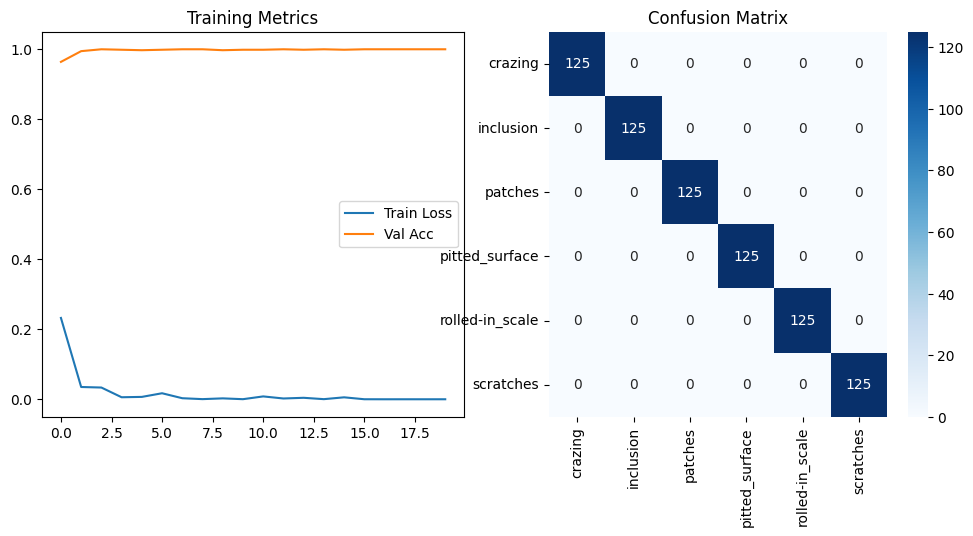

⏳ Computing t-SNE...


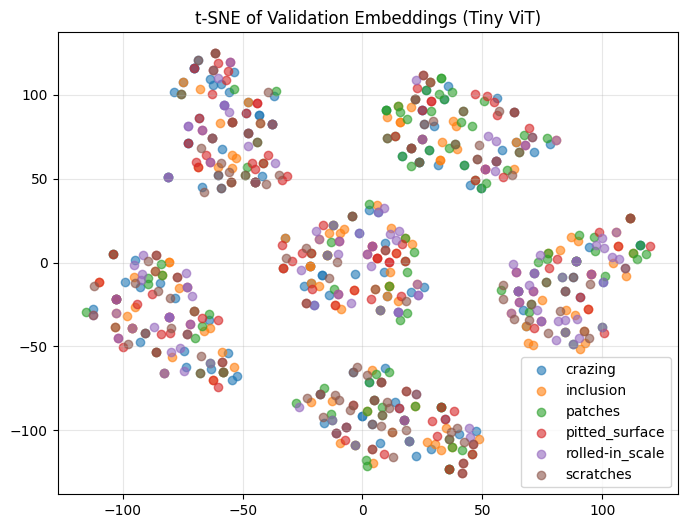

In [14]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets, transforms
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import timm  # <--- NEW LIBRARY
import gc

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'data_dir': '/kaggle/input/neu-surface-defect-database/NEU-DET',
    'image_size': 224,
    'n_way': 6,
    'n_support': 1,      
    'n_query': 5,        
    'episodes_train': 100,
    'episodes_val': 25,
    'epochs': 20,           # Good amount for Tiny ViT
    'learning_rate': 1e-4,  # Standard fine-tuning rate
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"Using device: {CONFIG['device']}")

# ==========================================
# 2. Data Loading (Standard)
# ==========================================
class EpisodicSampler(Sampler):
    def __init__(self, dataset, n_way, n_support, n_query, episodes):
        self.dataset = dataset
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.episodes = episodes
        self.indices_by_class = {}
        
        if hasattr(dataset, 'indices'): 
             for idx_in_subset, idx_in_full in enumerate(dataset.indices):
                label = dataset.dataset.targets[idx_in_full]
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx_in_subset)
        else:
            for idx, (_, label) in enumerate(dataset.samples):
                if label not in self.indices_by_class: self.indices_by_class[label] = []
                self.indices_by_class[label].append(idx)
            
    def __iter__(self):
        for _ in range(self.episodes):
            batch = []
            available_classes = list(self.indices_by_class.keys())
            if self.n_way > len(available_classes):
                selected_classes = available_classes
            else:
                selected_classes = random.sample(available_classes, self.n_way)
            
            for cls in selected_classes:
                indices = self.indices_by_class[cls]
                n_total = self.n_support + self.n_query
                replace = len(indices) < n_total
                selected_indices = np.random.choice(indices, n_total, replace=replace)
                batch.extend(selected_indices)
            yield batch

    def __len__(self):
        return self.episodes

def get_dataloaders():
    train_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    train_dir = os.path.join(CONFIG['data_dir'], 'train/images')
    val_dir = os.path.join(CONFIG['data_dir'], 'validation/images')
    
    full_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) 
    class_names = full_dataset.classes
    
    if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
        print(f"✅ Found separate Validation folder at: {val_dir}")
        train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
        val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
    else:
        print("⚠️ No Validation folder found. Performing split.")
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_sampler = EpisodicSampler(train_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_train'])
    val_sampler = EpisodicSampler(val_dataset, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['episodes_val'])

    train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=2, pin_memory=True)

    return train_loader, val_loader, class_names

# ==========================================
# 3. Model: Pretrained Tiny ViT
# ==========================================
class SwinTinyProtoNet(nn.Module):
    def __init__(self):
        super(SwinTinyProtoNet, self).__init__()
        
        # Load Pretrained Swin Tiny from TIMM
        # 'swin_tiny_patch4_window7_224' is the standard tiny variant
        self.backbone = timm.create_model(
            'swin_tiny_patch4_window7_224', 
            pretrained=True, 
            num_classes=0 # Remove head
        )
        
        # Swin Tiny output dimension is 768 (Standard for Swin/ViT-Base)
        # Note: This is larger than TinyViT's 192, so it holds more information
        self.embed_dim = 768 
        
        # Projection Head
        # We project 768 -> 128 -> 64 to keep the metric space clean
        self.projection = nn.Sequential(
            nn.Linear(self.embed_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1), # Added dropout for slight regularization
            nn.Linear(256, 64) 
        )
            
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

def euclidean_dist(x, y):
    n = x.size(0); m = y.size(0); d = x.size(1)
    if d != y.size(1): raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

def proto_loss_logic(model, data, n_way, n_support, n_query, device):
    data = data.view(n_way, n_support + n_query, 3, 224, 224)
    support_imgs = data[:, :n_support].contiguous().view(-1, 3, 224, 224)
    query_imgs = data[:, n_support:].contiguous().view(-1, 3, 224, 224)
    
    support_embeddings = model(support_imgs).view(n_way, n_support, -1)
    prototypes = support_embeddings.mean(dim=1)
    query_embeddings = model(query_imgs)
    
    dists = euclidean_dist(query_embeddings, prototypes)
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = target_inds.to(device).view(-1)
    
    log_p_y = torch.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, target_inds.view(-1, 1)).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(1)
    acc = torch.eq(y_hat, target_inds).float().mean()
    
    return loss, acc, y_hat, target_inds, query_embeddings, prototypes

# ==========================================
# 4. Training Engine
# ==========================================
def train_and_evaluate():
    torch.cuda.empty_cache(); gc.collect()
    train_loader, val_loader, class_names = get_dataloaders()
    model = SwinTinyProtoNet().to(CONFIG['device'])
    
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    scaler = GradScaler('cuda')
    
    history = {'train_loss': [], 'val_acc': []}

    print(f"\n🚀 Training Start | Model: Pretrained Tiny ViT | Classes: {len(class_names)}")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        avg_loss = 0
        for data, _ in train_loader:
            data = data.to(CONFIG['device'])
            optimizer.zero_grad()
            with autocast('cuda'):
                loss, _, _, _, _, _ = proto_loss_logic(
                    model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            avg_loss += loss.item()
            
        avg_loss /= len(train_loader)
        history['train_loss'].append(avg_loss)
        
        # Validation
        model.eval()
        avg_acc = 0
        all_preds = []; all_targets = []
        tsne_embeddings = []; tsne_labels = []
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(CONFIG['device'])
                with autocast('cuda'):
                    loss, acc, y_hat, y_true, q_emb, _ = proto_loss_logic(
                        model, data, CONFIG['n_way'], CONFIG['n_support'], CONFIG['n_query'], CONFIG['device']
                    )
                avg_acc += acc.item()
                
                if epoch == CONFIG['epochs'] - 1:
                    all_preds.extend(y_hat.cpu().numpy())
                    all_targets.extend(y_true.cpu().numpy())
                    tsne_embeddings.append(q_emb.cpu())
                    tsne_labels.append(y_true.cpu())

        avg_acc /= len(val_loader)
        history['val_acc'].append(avg_acc)
        scheduler.step()
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {avg_acc:.4f}")

    return history, all_preds, all_targets, class_names, tsne_embeddings, tsne_labels

# ==========================================
# 5. Visualization
# ==========================================
def run_analysis(history, preds, targets, class_names, embeddings, labels):
    print("\n📊 Classification Report:")
    print(classification_report(targets, preds, target_names=class_names))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend(); plt.title("Training Metrics")
    
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.show()
    
    print("⏳ Computing t-SNE...")
    all_emb = torch.cat(embeddings, dim=0).numpy()
    all_lbl = torch.cat(labels, dim=0).numpy()
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    emb_2d = tsne.fit_transform(all_emb)
    
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        idxs = all_lbl == i
        plt.scatter(emb_2d[idxs, 0], emb_2d[idxs, 1], label=class_name, alpha=0.6)
    
    plt.title("t-SNE of Validation Embeddings (Tiny ViT)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    try:
        hist, preds, targs, classes, embs, labs = train_and_evaluate()
        run_analysis(hist, preds, targs, classes, embs, labs)
    except Exception as e:
        print(f"❌ Error: {e}")